In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# attrition = pd.read_csv("/projects/cmpt889/uc3/Attrition - Data.csv")
attrition = pd.read_csv("/content/drive/MyDrive/shared/UseCase_3/Attrition_Data.csv")

inactive_ids = attrition.loc[attrition['Status'] == "Inactive", "New_ID"].unique().tolist()
closed_ids = attrition.loc[attrition['Status'] == "Closed", "New_ID"].unique().tolist()
inactive_closed_ids = inactive_ids + closed_ids
active_ids = [id for id in attrition["New_ID"].unique().tolist() if id not in inactive_closed_ids]

# basic data cleaning
attrition.loc[attrition['Has_Payroll'] == "Yes", "Has_Payroll"] = 1
attrition.loc[attrition['Has_Payroll'] == "yes", "Has_Payroll"] = 1
attrition.loc[attrition['Has_Payroll'] == "No", "Has_Payroll"] = 0


print(len(active_ids))
print(len(inactive_ids))
print(len(closed_ids))

8776
1575
51


In [ ]:
attrition_active = attrition.loc[attrition['New_ID'].isin(active_ids), :].copy().sort_values(['New_ID', 'Month'], ascending=[True, True]).reset_index(drop=True)
attrition_active.head()

attrition_active['time_string'] = attrition_active['Month'].astype(str)
attrition_active['year'] = attrition_active['time_string'].str.slice(start=0, stop=4).astype(int)
attrition_active['month_int'] = attrition_active['time_string'].str.slice(start=4, stop=6).astype(int)
attrition_active['time'] = (attrition_active['year'] - 2018) * 12 + attrition_active['month_int']

# create delta features: (value at time t) - (value at time t-1)

# drop Month, time_string, year, month_int
attrition_active = attrition_active.drop(columns=['Month', 'time_string', 'month_int'])

attrition_active["FUA_delta"] = attrition_active.groupby("New_ID")["FUA"].pct_change() * 100
attrition_active["Txn_delta"] = attrition_active.groupby("New_ID")["Txn"].pct_change() * 100

attrition_active["Services_delta"] = attrition_active.groupby("New_ID")["Services"].diff()
attrition_active["Services_delta"].fillna(0, inplace=True)

attrition_active["Has_Payroll_delta"] = attrition_active.groupby("New_ID")["Has_Payroll"].diff()
attrition_active["Has_Payroll_delta"].fillna(0, inplace=True)

attrition_active["Has_Investment_delta"] = attrition_active.groupby("New_ID")["Has_Investment"].diff()
attrition_active["Has_Investment_delta"].fillna(0, inplace=True)

attrition_active["Has_VISA_delta"] = attrition_active.groupby("New_ID")["Has_VISA"].diff()
attrition_active["Has_VISA_delta"].fillna(0, inplace=True)

attrition_active["Beacon_Score_delta"] = attrition_active.groupby("New_ID")["Beacon score"].diff()
attrition_active["Beacon_Score_delta"].fillna(0, inplace=True)

# split the Age into groups
attrition_active['Age_group'] = pd.cut(attrition_active['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Age_group as numeric
attrition_active['Age_group'] = attrition_active['Age_group'].astype(int)

# display(attrition_active.head())

# Take the newest record for each customer
attrition_active2 = attrition_active.loc[(attrition_active['New_ID'].isin(active_ids)) & (attrition_active['time'] == 48), :].copy().sort_values(['New_ID', 'time'], ascending=[True, True]).reset_index(drop=True)
attrition_active2.head()

,New_ID,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon score,year,time,FUA_delta,Txn_delta,Services_delta,Has_Payroll_delta,Has_Investment_delta,Has_VISA_delta,Beacon_Score_delta,Age_group
0,aaa6489015d,44.0,Active,328076.0,8.0,1,0.0,0.0,48.0,583.0,2021,48,0.020121,41.935484,0.0,0,0.0,0.0,0.0,4
1,aad1130444h,21.0,Active,97304.0,4.0,1,1.0,1.0,46.0,627.0,2021,48,0.035983,23.529412,0.0,0,0.0,0.0,0.0,4
2,aae309962v,29.0,Active,237206.0,4.0,1,0.0,0.0,59.0,586.0,2021,48,0.023614,0.000000,0.0,0,0.0,0.0,0.0,5
3,aaf2339482j,52.0,Active,116548.0,4.0,1,0.0,0.0,58.0,580.0,2021,48,0.010297,15.555556,0.0,0,0.0,0.0,0.0,5
4,aaf7563498g,42.0,Active,285622.0,4.0,1,0.0,0.0,66.0,625.0,2021,48,0.019260,23.529412,0.0,0,0.0,0.0,0.0,6


Text(0, 0.5, 'Count')

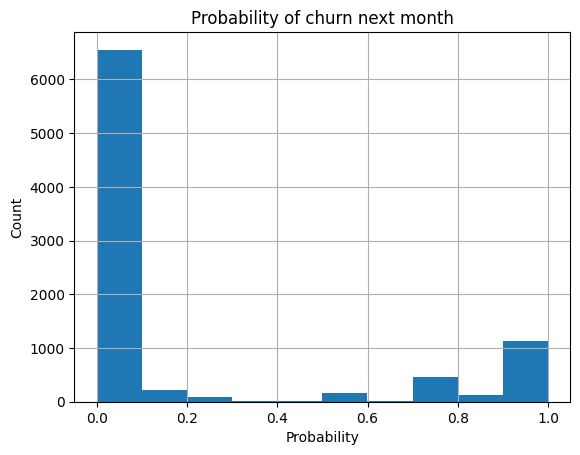

In [ ]:
# load trained gbm

import pickle
# with open('/projects/cmpt889/uc3/sonny/B02_gbm3.pkl', 'rb') as f:
#     gbm_model = pickle.load(f)
with open("/content/drive/MyDrive/shared/UseCase_3/sonny/B02_gbm3.pkl", 'rb') as f:
    gbm_model = pickle.load(f)

# make prediction
attrition_active2["pred"] = gbm_model.predict(attrition_active2[["FUA_delta", "Txn_delta", "Has_Payroll_delta", "Age_group", "time", "Services", "Beacon score"]])

# plot histogram of prediction
import matplotlib.pyplot as plt
# title : probability of churn next month
# x-axis : probability

attrition_active2['pred'].hist()
plt.title("Probability of churn next month")
plt.xlabel("Probability")
plt.ylabel("Count")

In [ ]:
# for each customer New_ID in attrition_active, filter out year == 2021, then calculate the average FUA and Txn. Name the mean columns as FUA_mean and Txn_mean.
attrition_active_mean = attrition_active.loc[attrition_active['year'] == 2021, :].groupby('New_ID').agg({'FUA': 'mean', 'Txn': 'mean'}).reset_index()
attrition_active_mean.columns = ['New_ID', 'FUA_mean', 'Txn_mean']
attrition_active_mean.head()

,New_ID,FUA_mean,Txn_mean
0,aaa6489015d,328123.416667,35.083333
1,aad1130444h,97448.166667,19.416667
2,aae309962v,237173.250000,20.916667
3,aaf2339482j,116547.833333,44.083333
4,aaf7563498g,285529.750000,40.750000


,Txn,FUA,Services,Has_Investment,Has_VISA,Age,Beacon score,year,time,FUA_delta,Txn_delta,Services_delta,Has_Payroll_delta,Has_Investment_delta,Has_VISA_delta,Beacon_Score_delta,Age_group,pred,FUA_mean,Txn_mean
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.0,300.0,300.000000,300.000000,300.0,300.000000,300.0,300.0,300.0,300.000000,300.000000,300.000000,300.000000
mean,11.536667,204128.403333,4.720000,0.476667,0.526667,49.110000,677.796667,2021.0,48.0,-17.607424,-58.178943,0.0,-0.193333,0.0,0.0,0.0,4.370000,0.855275,229700.169722,22.672778
std,5.924440,103995.028915,1.376438,0.500290,0.500123,16.091853,77.519845,0.0,0.0,36.101715,16.337912,0.0,0.395572,0.0,0.0,0.0,1.643809,0.152380,61854.076779,8.098062
min,0.000000,143.000000,3.000000,0.000000,0.000000,22.000000,550.000000,2021.0,48.0,-99.905217,-100.000000,0.0,-1.000000,0.0,0.0,0.0,2.000000,0.514913,132287.416667,11.416667
25%,9.000000,168780.750000,4.000000,0.000000,0.000000,36.000000,611.750000,2021.0,48.0,-0.035972,-64.518634,0.0,0.000000,0.0,0.0,0.0,3.000000,0.791753,168916.020833,17.000000
50%,11.000000,232905.000000,4.000000,0.000000,1.000000,49.000000,677.000000,2021.0,48.0,-0.015673,-56.666667,0.0,0.000000,0.0,0.0,0.0,4.000000,0.934914,232918.375000,19.083333
75%,13.000000,288332.750000,5.000000,1.000000,1.000000,62.000000,743.000000,2021.0,48.0,0.009435,-50.000000,0.0,0.000000,0.0,0.0,0.0,6.000000,0.938567,288462.104167,31.000000
max,36.000000,332783.000000,8.000000,1.000000,1.000000,83.000000,817.000000,2021.0,48.0,0.053030,0.000000,0.0,0.000000,0.0,0.0,0.0,8.000000,0.998441,332906.000000,42.333333


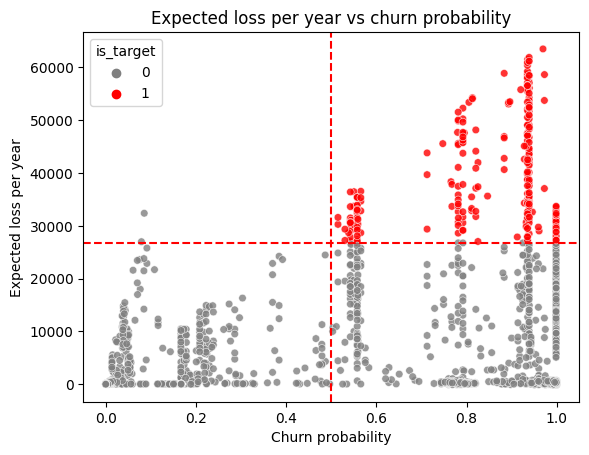

In [ ]:
# Customer evaluation: Compute expected profit per year based on assumptions:

FUA_margin = 0.2        # - We earn 2% margin on FUA per year
Txn_profit = 0.2        # - We earn $2 per 10 transactions per month
Payroll_profit = 120    # - We earn $120 per year if the customer has payroll
Investment_profit = 120 # - We earn $360 per year if the customer has investment
VISA_profit = 120       # - We earn $360 per year if the customer has VISA
Services_profit = 24    # - We earn $60 per service per yer

churn_cutpoint = 0.5

attrition_active3 = attrition_active2.copy()

# merge attrition_active3 with attrition_active_mean by New_ID
attrition_active3 = attrition_active3.merge(attrition_active_mean, on='New_ID', how='left')
# attrition_active3.head()

# # compute expected profit per year using the means
attrition_active3['expected_profit_year'] = (attrition_active3['FUA_mean'] * FUA_margin) + (attrition_active3['Txn_mean'] * Txn_profit)*12 + (attrition_active3['Has_Payroll'] * Payroll_profit) + (attrition_active3['Has_Investment'] * Investment_profit) + (attrition_active3['Has_VISA'] * VISA_profit) + (attrition_active3['Services'] * Services_profit)

# # Based on the above assumptions, compute expected loss per year
attrition_active3['expected_loss'] = attrition_active3['pred'] * attrition_active3['expected_profit_year']
# attrition_active3.head()

# select targets: top 300 customers with highest expected loss per year
call_targets = attrition_active3.loc[attrition_active3['pred'] > churn_cutpoint, :].sort_values(by = ['expected_loss'], ascending= False).iloc[0:300, :].reset_index(drop=True)
# display(call_targets.tail())
display(call_targets.describe())

# Plot
import seaborn as sns

horiz_value = np.min(call_targets['expected_loss'])

# plot scatterplot of expected loss vs churn probability
p_df = attrition_active3.copy()
p_df['is_target'] = 0
p_df.loc[(p_df['pred'] > churn_cutpoint) & (p_df['expected_loss'] > horiz_value), 'is_target'] = 1
# display(p_df.head())

sns.scatterplot(x="pred", y="expected_loss", data=p_df, alpha=0.8, s = 30, hue="is_target", palette = ["Grey", "Red"])
plt.title("Expected loss per year vs churn probability")
plt.xlabel("Churn probability")
plt.ylabel("Expected loss per year")
# draw a horizontal line at y = 1196.4

# churn_cutpoint = np.min(call_targets['pred'])
plt.axhline(y=horiz_value, color='r', linestyle='dashed')
plt.axvline(x=churn_cutpoint, color='r', linestyle='dashed')
plt.show()

Here, we call the 300 customers in the upper right corner of the graph.

(Think of a name for each segment?)


In [ ]:
np.min(call_targets['expected_loss'])

26782.553601857857

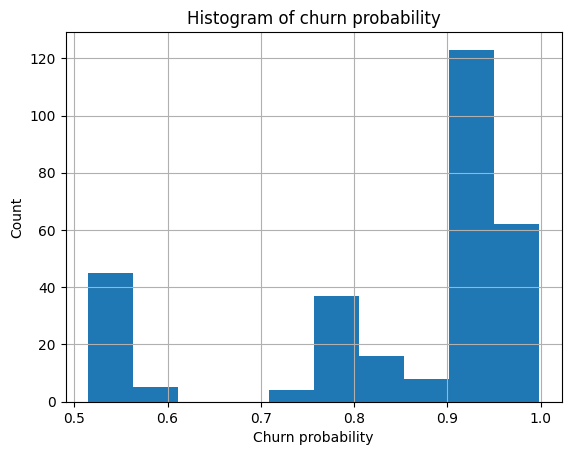

In [ ]:
call_targets['pred'].hist()
plt.title("Histogram of churn probability")
plt.xlabel("Churn probability")
plt.ylabel("Count")
plt.show()

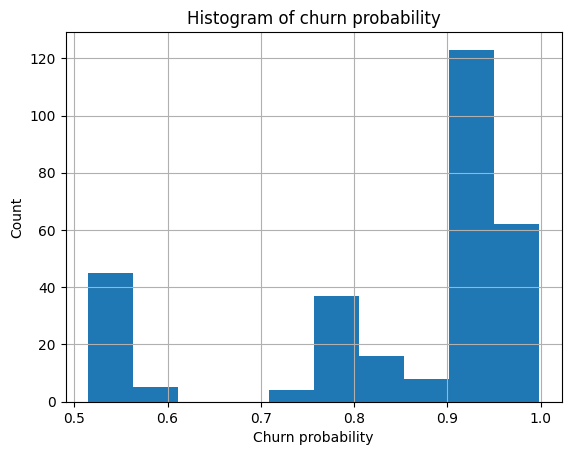

In [ ]:
call_targets['pred'].hist()
plt.title("Histogram of churn probability")
plt.xlabel("Churn probability")
plt.ylabel("Count")
plt.show()

array([[<Axes: title={'center': 'FUA_mean'}>,
        <Axes: title={'center': 'FUA_delta'}>,
        <Axes: title={'center': 'Txn_mean'}>],
       [<Axes: title={'center': 'Txn_delta'}>,
        <Axes: title={'center': 'Has_Payroll_delta'}>,
        <Axes: title={'center': 'Age_group'}>],
       [<Axes: title={'center': 'Has_Investment'}>,
        <Axes: title={'center': 'Has_VISA'}>,
        <Axes: title={'center': 'Services'}>],
       [<Axes: title={'center': 'pred'}>, <Axes: >, <Axes: >]],
      dtype=object)

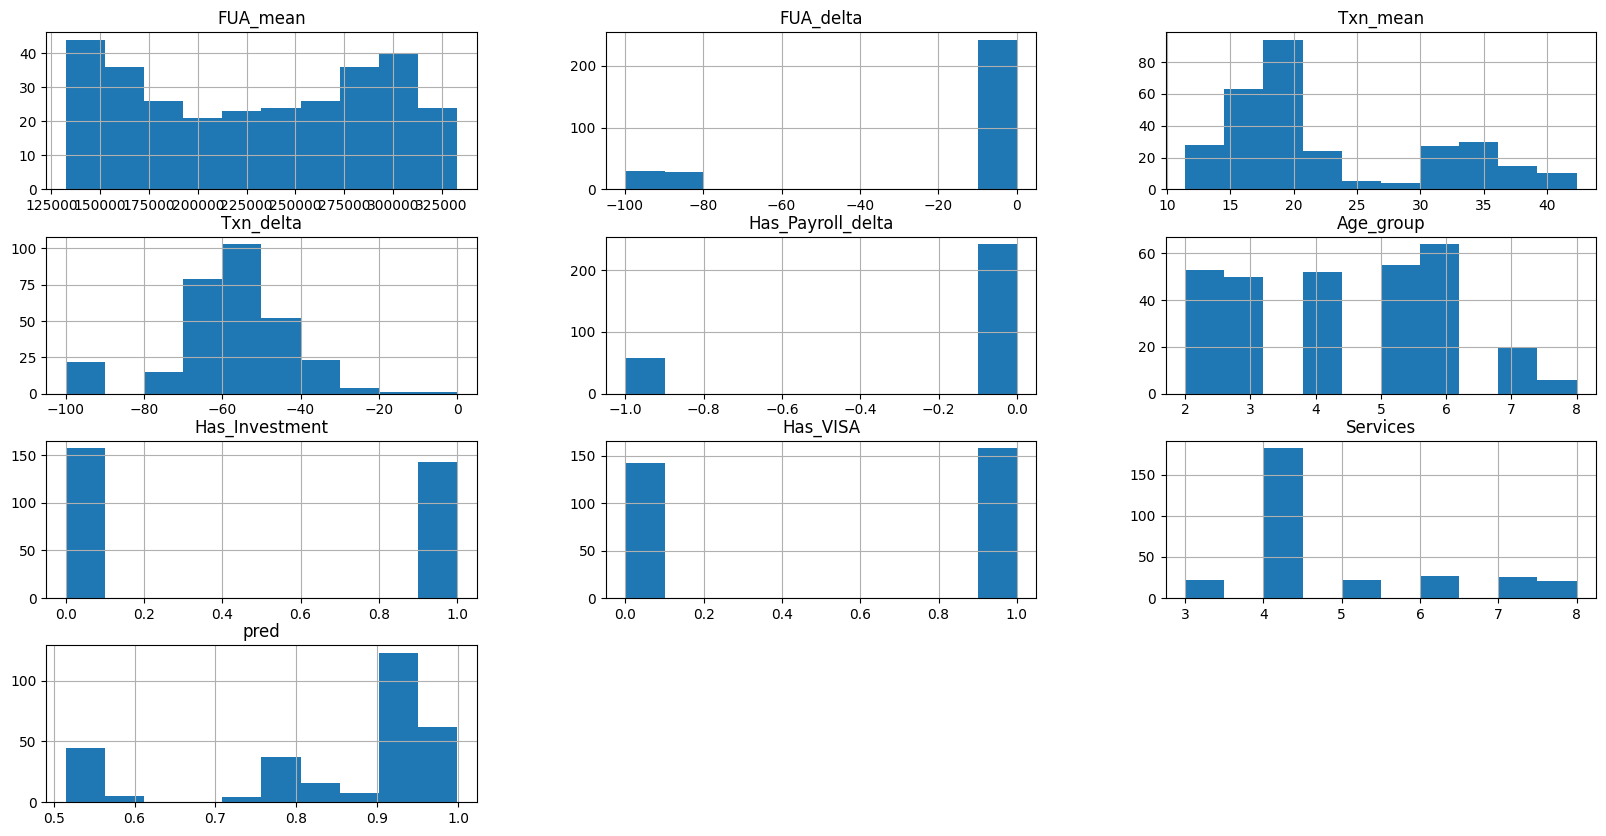

In [ ]:
# check the characteristics of the call_targets
call_targets[['FUA_mean', 'FUA_delta', 'Txn_mean', 'Txn_delta', 'Has_Payroll', 'Has_Payroll_delta', 'Age_group', 'Has_Investment', 'Has_VISA', 'Services', 'pred']].hist(figsize=(20, 10))